In [12]:
#Imports
from src.PCA import ComputeCovariance
from src.dim_red_viz import visualize_manifold_method
#REDO this to just import a function
from src.data.dimensionality_reduction.choose_dimension import choose_dimension
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from rpy2.robjects.packages import importr
import rpy2.robjects as ro
from rpy2.robjects import r, pandas2ri
from sklearn.manifold import Isomap, SpectralEmbedding, LocallyLinearEmbedding
from copy import copy 
from sklearn.manifold import trustworthiness
from kneed import DataGenerator, KneeLocator
from rpy2.robjects.conversion import localconverter
import pickle
import os
from matplotlib.colors import ListedColormap
from matplotlib import gridspec
import matplotlib.dates as mdates
from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU
import scipy
from datetime import datetime
from sklearn.metrics.pairwise import cosine_similarity
plt.rcParams['figure.dpi'] = 600

In [13]:
print(os.path.abspath(os.path.join(os.getcwd(), '..', 'reports')))

/home/rlevin/covid-mobility-and-behavior/reports


In [14]:
# from rpy2.robjects.packages import importr
# utils = importr('utils')
# utils.install_packages('mclust')

In [15]:
STATE = 'wa'

#Shape files:
WASHINGTON_SHAPE_PATH = os.path.abspath(os.path.join(os.getcwd(), '..', 'data', 'external', 'washington_blockgroup_shape', 'tl_2015_53_bg', 'tl_2015_53_bg.shp'))
TEXAS_SHAPE_PATH = os.path.abspath(os.path.join(os.getcwd(), '..','data','external','texas_blockgroup_shape','tl_2016_48_bg','tl_2016_48_bg.shp'))
GEORGIA_SHAPE_PATH = os.path.abspath(os.path.join(os.getcwd(), '..','data','external', 'georgia_blockgroup_shape','tl_2017_13_bg.shp'))
CALIFORNIA_SHAPE_PATH = os.path.abspath(os.path.join(os.getcwd(), '..','data','external', 'california_blockgroup_shape','tl_2016_06_bg.shp'))

#Figures:
WASHINGTON_FIGURE_PATH = os.path.abspath(os.path.join(os.getcwd(), '..', 'reports', 'figures', 'WA'))
TEXAS_FIGURE_PATH = os.path.abspath(os.path.join(os.getcwd(), '..', 'reports', 'figures', 'TX'))
GEORGIA_FIGURE_PATH = os.path.abspath(os.path.join(os.getcwd(), '..', 'reports', 'figures', 'GA'))
CALIFORNIA_FIGURE_PATH = os.path.abspath(os.path.join(os.getcwd(), '..', 'reports', 'figures', 'CA'))

#Data:
DATA_PATH = os.path.abspath(os.path.join(os.getcwd(), '..', 'data'))
WASHINGTON_RAW_DATA_PATH = os.path.abspath(os.path.join(os.getcwd(), '..', 'data', 'raw', 'stayathome-washington.csv'))
GEORGIA_RAW_DATA_PATH = os.path.abspath(os.path.join(os.getcwd(), '..', 'data', 'raw', 'stayathome-georgia.csv'))
TEXAS_RAW_DATA_PATH = os.path.abspath(os.path.join(os.getcwd(), '..', 'data', 'raw', 'stayathome-texas.csv'))
CALIFORNIA_RAW_DATA_PATH = os.path.abspath(os.path.join(os.getcwd(), '..', 'data', 'raw', 'stayathome-california.csv'))

def define_paths(STATE):
    if STATE == 'wa':
        SHAPE_PATH = WASHINGTON_SHAPE_PATH
        FIGURE_PATH = WASHINGTON_FIGURE_PATH
        RAW_DATA_PATH = WASHINGTON_RAW_DATA_PATH
    if STATE == 'tx':
        SHAPE_PATH = TEXAS_SHAPE_PATH
        FIGURE_PATH = TEXAS_FIGURE_PATH
        RAW_DATA_PATH = TEXAS_RAW_DATA_PATH
#         DATA_PATH  = 
    if STATE == 'ga':
        SHAPE_PATH = GEORGIA_SHAPE_PATH
        FIGURE_PATH = GEORGIA_FIGURE_PATH
        RAW_DATA_PATH = GEORGIA_RAW_DATA_PATH
    if STATE == 'ca':
        SHAPE_PATH = CALIFORNIA_SHAPE_PATH
        FIGURE_PATH = CALIFORNIA_FIGURE_PATH
        RAW_DATA_PATH = CALIFORNIA_RAW_DATA_PATH
    return SHAPE_PATH, FIGURE_PATH, RAW_DATA_PATH

SHAPE_PATH, FIGURE_PATH, RAW_DATA_PATH = define_paths(STATE)
SHAPE_PATH, FIGURE_PATH, RAW_DATA_PATH

('/home/rlevin/covid-mobility-and-behavior/data/external/washington_blockgroup_shape/tl_2015_53_bg/tl_2015_53_bg.shp',
 '/home/rlevin/covid-mobility-and-behavior/reports/figures/WA',
 '/home/rlevin/covid-mobility-and-behavior/data/raw/stayathome-washington.csv')

In [16]:
define_paths('wa')

('/home/rlevin/covid-mobility-and-behavior/data/external/washington_blockgroup_shape/tl_2015_53_bg/tl_2015_53_bg.shp',
 '/home/rlevin/covid-mobility-and-behavior/reports/figures/WA',
 '/home/rlevin/covid-mobility-and-behavior/data/raw/stayathome-washington.csv')

In [17]:
#Load the data
def load_data(RAW_DATA_PATH):
    covid_ga = pd.read_csv(RAW_DATA_PATH)
    covid_ga_ = covid_ga.set_index('Unnamed: 0')
    covid_ga_ = covid_ga_[covid_ga_.columns[:117]] #to consider the same time period with our WA analysis
    #Prepare the data: drop nans
    X = covid_ga_.dropna().values
    index_X = covid_ga_.dropna().index
    columns_X = covid_ga_.dropna().columns
    print('Data loaded:', X.shape, covid_ga_.shape)
    return covid_ga_, X, index_X, columns_X


In [494]:
#Define functions
import scipy
from datetime import datetime
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import Isomap

def convert_to_python_dict(mc):
    return dict(zip(mc.names, list(mc)))

def save_obj(obj, name ):
    with open(os.path.join('obj', name + '.pkl'), 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open(os.path.join('obj', name + '.pkl'), 'rb') as f:
        return pickle.load(f)
    
def find_closest_time_series(SE_behavior, SE_means, covid_, index_X, n = 5):
    """Finds n closest time series to the cluster means (or the vectors in SE_means)
    returns dict with keys V1...V6 cluster names and values dataframes with the n closest samples
    same for block_ids    
    """
    #ADD index_X here!!!
    closest_to_mean_samples = {}
    closest_to_mean_block_ids = {}
    for cluster in SE_means.columns:
        sorted_indices = np.squeeze(np.argsort(scipy.spatial.distance.cdist(SE_behavior, SE_means[cluster][None,:], metric='euclidean'), axis = 0))
        closest_to_mean_samples[cluster] = covid_.loc[index_X[sorted_indices[:n]]] #Take the closest n points
        closest_to_mean_block_ids[cluster] = index_X[sorted_indices[:n]]
    return closest_to_mean_samples, closest_to_mean_block_ids


def plot_time_series(time_series_df, name = 'time_series_of_interest', filename = None, only_melt = False):
#     FIGURES_PATH = '/home/rlevin/notebooks/notebooks/datadrivenmethodsforgemspoliocovid/reports/figures/'
    time_series_df_ = time_series_df.copy().T
    time_series_df_['dates'] = pd.to_datetime(time_series_df.columns)
    #closest_to_mean_sample_ = closest_to_mean_sample.T
    #closest_to_mean_sample_['dates'] = pd.to_datetime(columns_X)
#     closest_to_mean_sample_
    #Cluster means figure
    sns.set(style="darkgrid")
#     sns.set_palette("tab10")
    melted_df = pd.melt(time_series_df_,
                        id_vars=['dates'], # Variables to keep
                        var_name="Block")
    if only_melt:
        return melted_df
    g = sns.relplot(x = 'dates', y="value", row = 'Block', 
                    kind="line", row_order=time_series_df.index, data=melted_df, sort = False, aspect = 5, marker='o')
    g.fig.autofmt_xdate(0,10)
    plt.subplots_adjust(top=0.93)
    g.fig.suptitle(name, size = 'xx-large')
    g.set(ylim=(0, 1))


    #Add the important dates
    # ax = g.axes[1]

    for axs in g.axes:
        axs[0].axvline(datetime(2020, 2, 29), color = 'green', ls='--', label='emergency_WA')
        axs[0].axvline(datetime(2020, 3, 3), color = 'blue', ls='--', label='emergency_Seattle')
        axs[0].axvline(datetime(2020, 3, 11), color = 'red', ls='--', label='events_ban')
        axs[0].axvline(datetime(2020, 3, 12), color = 'brown', ls='--', label='schools')
        axs[0].axvline(datetime(2020, 3, 15), color = 'green', ls='-', label='restrautrants')
        axs[0].axvline(datetime(2020, 3, 21), color = 'blue', ls='-', label='Everett_stay_home')
        axs[0].axvline(datetime(2020, 3, 23), color = 'red', ls='-', label='stay-at-home')
        axs[0].axvline(datetime(2020, 3, 25), color = 'brown', ls='-', label='WA_parks_closed')
        axs[0].axvline(datetime(2020, 3, 31), color = 'green', ls='-.', label='National_guard_WA')
        axs[0].axvline(datetime(2020, 4, 2), color = 'blue', ls='-.', label='stay-at-home_extended')

        axs[0].legend()

    # ax[0].text(0.5,25, "Some text")
    if filename is not None:
        g.fig.savefig(filename + '.png', bbox_inches = 'tight')
    
    return melted_df
        
def viz_blocks_on_the_map(block_ids, colors, name = 'blocks_of_interest', filename = None, cmap = None):#, washington_ = washington_):
#     FIGURES_PATH = '/home/rlevin/notebooks/notebooks/datadrivenmethodsforgemspoliocovid/reports/figures/'
    if cmap is not None:
        almost_sequential_pal = ['#1f78b4','#a6cee3','#fdbf6f','#ff7f00', '#cc78bc']
        friendly_cmap = ListedColormap(sns.color_palette(almost_sequential_pal, len(np.unique(colors)), desat = 0.75).as_hex())#'colorblind'
    else:
        friendly_cmap = None
    washington = gpd.read_file(SHAPE_PATH)
#     washington_ = washington.copy()
#     washington_.GEOID = washington_.GEOID.astype('int')
#     washington_ = washington_.set_index('GEOID')
    washington['blocks_of_interest'] = np.nan
    washington['blocks_of_interest'][washington.GEOID.astype('int').isin(block_ids.astype('int'))] = colors
#     colors = pd.DataFrame(colors, columns = ['c'])
#     colors['block_ind'] = index_X
#     colors = colors.set_index('block_ind')
#     washington_['colormap'] = colors['c']
    fig, ax = plt.subplots(figsize=(12, 10))
    ax.axis('off')
    washington.plot(column = 'blocks_of_interest', ax = ax, legend = False, edgecolor="face", cmap = cmap,
                    linewidth=0.4, legend_kwds={'label': 'Cluster','orientation': "horizontal"})
    ax.set(title=name)
    if filename is not None:
        fig.savefig(os.path.join(FIGURE_PATH, filename + '.png'), dpi = 360, bbox_inches = 'tight')
        
def viz_SE(X, colors, filename = None, alpha = None, cbar = None, subselect = slice(None), ax = None, load_path = None, save_path = None): 
    #Try Spectral Embedding
    from sklearn.manifold import SpectralEmbedding

    emb_method = SpectralEmbedding

    hyperparams_to_test = {}#{'n_neighbors': [50, 50]}
#     colors = colors#labels_multirun['Labels_3']#SE_clusters['x'].values
    SE_X_2D_emb, SE_X_3D_emb = visualize_manifold_method(X, emb_method, hyperparams_to_test, colors, '', filename = filename,
                                                         alpha = alpha, cbar = cbar, subselect = subselect, ax = ax, 
                                                         load_path = load_path, save_path = save_path, **{'n_neighbors': 50,
     'n_components': 2,
     'n_jobs': -1})
    
    return SE_X_2D_emb, SE_X_3D_emb


        
def viz_Isomap(X, colors, filename = None, alpha = None, cbar = None, subselect = slice(None), ax = None, load_path = None, save_path = None):
    emb_method = Isomap
    hyperparams_to_test = {}#{'n_neighbors': [50, 50]}
#     colors = colors#SE_clusters['x'].values#lusters[:,1]

    Isomap_X_2D_emb, Isomap_X_3D_emb = visualize_manifold_method(X, emb_method, hyperparams_to_test, colors,
                              '', filename = filename, 
                              alpha = alpha, cbar = cbar, subselect = subselect, ax = ax, 
                                                                 load_path = load_path, save_path = save_path, **{'n_neighbors': 50, 
                                                                    'n_components': 2, 
                                                                    'max_iter': 1000, 
                                                                    'n_jobs': -1})
    return Isomap_X_2D_emb, Isomap_X_3D_emb
    
def viz_LLE(X, colors, filename = None, alpha = None, cbar = None, subselect = slice(None), ax = None, load_path = None, save_path = None):
    #Try LLE, standard, tweaked parameters a little
    from sklearn.manifold import LocallyLinearEmbedding

    emb_method = LocallyLinearEmbedding
    hyperparams_to_test = {}#'n_neighbors': [200, 200],
    # colors = clusters[:,1]


    LLE_X_2D_emb, LLE_X_3D_emb = visualize_manifold_method(X, emb_method, hyperparams_to_test, colors,
                              '', filename = filename, 
                              alpha = alpha, cbar = cbar, subselect = subselect, ax = ax, load_path = load_path, 
                                                           save_path = save_path, **{'n_neighbors': 200,
                                                                       'n_components': 2,
                                                                       'reg': 0.1,
                                                                       'eigen_solver': 'auto',
                                                                       'tol': 1e-06,
                                                                       'max_iter': 1000,
                                                                       'method': 'standard',
                                                                       'hessian_tol': 0.0001,
                                                                       'modified_tol': 1e-12,
                                                                       'neighbors_algorithm': 'auto',  
                                                                       'random_state': None,
                                                                       'n_jobs': -1})
    return LLE_X_2D_emb, LLE_X_3D_emb
    
    
def viz_cluster_map(colors, index_X, filename = None, title = None, cbar_label = None, cmap = None, ax = None, edgecolor = 'lightgrey', linewidth = 0.3, desat = 1):#, washington_ = washington_):
#     FIGURES_PATH = '/home/rlevin/notebooks/notebooks/datadrivenmethodsforgemspoliocovid/reports/figures/'
    #FIX THIS FOR OTHER STATES!
#     sns.set_palette("tab10")
    if cmap is not None:
        almost_sequential_pal = ['#1f78b4','#a6cee3','#fdbf6f','#ff7f00', '#cc78bc']
        friendly_cmap = ListedColormap(sns.color_palette(almost_sequential_pal, len(np.unique(colors)), desat = desat).as_hex())#'colorblind'
    else:
        friendly_cmap = None
    washington = gpd.read_file(SHAPE_PATH)
    washington_ = washington.copy()
    washington_.GEOID = washington_.GEOID.astype('int')
    washington_ = washington_.set_index('GEOID')

    
    colors = pd.DataFrame(colors, columns = ['c'])
    colors['block_ind'] = index_X
    colors = colors.set_index('block_ind')
    washington_['colormap'] = colors['c']
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 10))
        ax.axis('off')
        washington_.plot(column = 'colormap', ax = ax, legend = True, edgecolor="face", cmap = friendly_cmap, linewidth=linewidth, legend_kwds={'label': cbar_label,'orientation': "horizontal"})
        ax.set(title= title)
    else:
        ax.axis('off')
        washington_.plot(column = 'colormap', ax = ax, legend = False, edgecolor=edgecolor, cmap = friendly_cmap, linewidth=linewidth, missing_kwds={'color': 'lightgrey'})
        ax.set(title = title)
#     cbar = ax[1]#.get_figure().get_axes()[1]
#     ticks = np.sort(np.unique(colors))[::-1]
#     cbar_clust = fig.colorbar(wa_plot, ticks = ticks)
        # print('CHECK CBAR:', np.sort(np.unique(colors))[::-1])
#     cbar.set_yticklabels(['Cluster ' + str(i) for i in ticks])
    if filename is not None:
        fig.savefig(filename + '.png', bbox_inches = 'tight')

        
def create_walk_df(X_emb, similarity, index):
    """X_emb -- embedding,
    similarity -- to sort by in the walk, colormap, the same dimension with X_emb
    index -- non-artifact index e.g., to subselect
    """
    similarities_non_artifact = similarity[index]
    X_walk = X_emb[index]
    X_walk_df = pd.DataFrame(X_walk, columns = ['Mode_{}'.format(i) for i in range(X_walk.shape[1])])
    X_walk_df['Similarity'] = similarities_non_artifact
    return X_walk_df.sort_values(by = 'Similarity')#.reset_index(drop = True)

def find_cos_similarity(X_2D_emb):
    right_end = X_2D_emb[np.argmax(X_2D_emb, axis = 0)[0]]
    left_end = X_2D_emb[np.argmin(X_2D_emb, axis = 0)[0]]
    left_end, right_end, np.argmin(X_2D_emb, axis = 0)[0]
    center = (left_end + right_end)/2
    cosine_colors = 1-cosine_similarity([right_end - center], X_2D_emb-center, dense_output=True).flatten()
    return cosine_colors

from scipy.spatial.distance import squareform, pdist

def intersection(f, g):
#     dates_of_intersection = f.index[38:]
    f1 = f[38:]
    g1 = g[38:]
    idx = np.argwhere(np.diff(np.sign(f1 - g1))).flatten()
    return len(idx)

def relabel_clusters(clusters, avg_per_clust, means, z, uncertainty):
    means = means.copy()
    num_clust = len(np.unique(clusters))
    intersections = pd.DataFrame(squareform(pdist(avg_per_clust, metric = intersection)), index = avg_per_clust.index, columns = avg_per_clust.index)
    #Define the one with more than 1 intersection as the off-manifold
    off_manifold = int(np.squeeze(np.where((intersections > 0).sum() > 1)))+1
    off_manifold_bool = ((intersections > 0).sum() > 1).values
    ordered_clusters_no_off_manifold = avg_per_clust.T.mean()[~off_manifold_bool].sort_values()#[::-1]
#     print(ordered_clusters_no_off_manifold)
    new_ordered_clusters = []
    new_ordered_mean_cols = {}
    for cluster in clusters:
#         print(clusters)
#         print(off_manifold)
        if cluster == off_manifold:
            new_ordered_clusters.append(num_clust)
            new_ordered_mean_cols['V'+str(cluster)] = 'V'+str(num_clust)
        else:
#             print('cluster: ', cluster)
#             print(ordered_clusters_no_off_manifold.index)
#             print(np.where(cluster == ordered_clusters_no_off_manifold.index))
            new_clust_label = int(np.squeeze(np.where(int(cluster) == ordered_clusters_no_off_manifold.index.astype('int'))))+1
            new_ordered_clusters.append(new_clust_label)
            new_ordered_mean_cols['V'+str(cluster)] = 'V'+str(new_clust_label)
            
    new_ordered_means = means.rename(columns = new_ordered_mean_cols)
    return np.array(new_ordered_clusters), new_ordered_means, pd.DataFrame(z, columns = new_ordered_means.columns), uncertainty


def GMM_clustering_R(X_SE_df, method, default_cluster_num = None):
    """Function to check BIC and perform GMM clustering on embedded dataset"""
    #First, import r packages and fix random seed:
    base = importr('base')
    mclust = importr('mclust')
    ro.r('set.seed(0)')
    
    #Now, check BIC and make a plot
    num_components_to_try = pd.Series(np.arange(1,12)) #try up to 12 components
    with localconverter(ro.default_converter + pandas2ri.converter):
        ro.r('set.seed(0)')
        BIC_SE = mclust.mclustBIC(X_SE_df, G = num_components_to_try)
    
    model_names = ['EII', 'VII', 'EEI', 'VEI', 'EVI', 'VVI', 'EEE', 'EVE', 'VEE', 'VVE', 'EEV', 'VEV', 'EVV', 'VVV']
    sns.set(style="darkgrid")
#     sns.set_palette("tab10")
    BIC_SE_df = pd.DataFrame(BIC_SE, columns = model_names)
#     plt.figure()
    BIC_SE_df.plot(marker = 'o')
    plt.title('GMM BIC on ' + method.__name__)
    
    #Now, find the knee point of the optimal BIC plot (the best GMM parametrization)
    best_parametrization = BIC_SE_df.columns[BIC_SE_df.max().argmax()]
    kneedle = KneeLocator(num_components_to_try, BIC_SE_df[best_parametrization], S=1, curve='concave', direction='increasing', interp_method='interp1d')
#     plt.figure()
    kneedle.plot_knee()
    plt.title('GMM BIC on ' + method.__name__ + ': Knee Point')
    plt.xlabel('num_GMM_components')
    plt.ylabel('')
    print('Elbow point: {} components with BIC {}'.format(kneedle.knee, kneedle.knee_y))
    
    #Pick the best number of GMM components:
    best_num_components = kneedle.knee-1
    if default_cluster_num is not None:
        best_num_components = default_cluster_num-1
    with localconverter(ro.default_converter + pandas2ri.converter):
        ro.r('set.seed(0)')
        mc = mclust.Mclust(X_SE_df, G = pd.Series([num_components_to_try[best_num_components]]))
        print(base.summary(mc))
        print(np.quantile(mc[15], [0, 0.25, 0.5, 0.75, 1]))
        mc_dict = convert_to_python_dict(mc)
        SE_model_name = mc_dict['modelName']
        print(SE_model_name)
        param = mc_dict['parameters']
        SE_means = np.array(convert_to_python_dict(param)['mean'])
        SE_uncertainty = np.array(mc_dict['uncertainty'])
        SE_z = np.array(convert_to_python_dict(mc)['z'])
        SE_clusters = np.array(convert_to_python_dict(mc)['classification'])
        SE_means = pd.DataFrame(SE_means, columns = ['V'+str(i+1) for i in range(SE_means.shape[1])])
#         np.array(mc[14])
#         SE_means = np.array(mc[12][1])
    return SE_clusters, SE_means, SE_z, SE_uncertainty

def create_avg_df(SE_clusters, index_X, covid_):
    SE_clusters_block_indexed = pd.Series(SE_clusters, index = index_X)
    df_CI = covid_.dropna()#[SE_clusters_block_indexed['x']==4]
    df_CI['cluster'] = SE_clusters_block_indexed.astype('int')
    df_CI['block'] = df_CI.index
    dates = df_CI.columns.drop(['block', 'cluster'])
    avg_per_clust = df_CI.groupby('cluster').mean()[dates]#[dates].plot()
    return avg_per_clust

def index_with_blocks_and_save(STATE, emb_df_optimal_D, emb_2D, emb_3D, clusters, z, uncertainty, index_X, emb_method):
    df_optimal_D = emb_df_optimal_D.set_index(index_X)
    df_2D = pd.DataFrame(emb_2D, columns = ['Mode ' + str(i) for i in range(emb_2D.shape[1])], index = index_X)
    df_3D = pd.DataFrame(emb_3D, columns = ['Mode ' + str(i) for i in range(emb_3D.shape[1])], index = index_X)
    df_clusters = pd.Series(clusters, index = index_X)
    df_z = z.set_index(index_X)
    df_uncertainty = pd.Series(uncertainty, index = index_X)
    
    #Save
    path_to_processed = os.path.join(DATA_PATH, 'processed')
    df_optimal_D.to_csv(os.path.join(path_to_processed, emb_method.__name__ + str(df_optimal_D.shape[1]) + 'D_' + STATE + '.csv'))
    df_2D.to_csv(os.path.join(path_to_processed, emb_method.__name__ + str(df_2D.shape[1]) + 'D_' + STATE + '.csv'))
    df_3D.to_csv(os.path.join(path_to_processed, emb_method.__name__ + str(df_3D.shape[1]) + 'D_' + STATE + '.csv'))
    df_clusters.to_csv(os.path.join(path_to_processed, 'labels_' + STATE + '.csv'))
    df_z.to_csv(os.path.join(path_to_processed, 'z_' + STATE + '.csv'))
    df_uncertainty.to_csv(os.path.join(path_to_processed, 'uncertainty_' + STATE + '.csv'))
    return df_optimal_D, df_2D, df_3D, df_clusters, df_z, df_uncertainty

def add_state_to_fig(state, fig, spec, row, NUM_STATES, X, reordered_SE_clusters, index_X, reordered_avg_per_clust, load_path = None, save_path = None, separate = False, two_cols = False):
    almost_sequential_pal = ['#1f78b4','#a6cee3','#fdbf6f','#ff7f00', '#cc78bc']
    sns.set_palette(almost_sequential_pal)
    NUM_COLS = 3
    if two_cols:
        NUM_COLS = 2
    SEPARATE_PATH = os.path.abspath(os.path.join(os.getcwd(), '..', 'reports', 'figures', 'Separate_Summary'))
    # First column
    if separate:
        fig = plt.figure(figsize = (5*7/3, 5*(6.25 - 0.77)/4))
        ax = fig.add_subplot(111, projection='3d')
    else:
        ax = fig.add_subplot(spec[NUM_COLS*row], projection = '3d')#NUM_STATES, NUM_COLS, NUM_COLS*row + 1, projection = '3d')
    ax.set_anchor('E')
    if two_cols:
        cbar = None
    else:
        cbar = 'clustering'
    _, X_3D_SE = viz_SE(X, reordered_SE_clusters, filename = None, alpha = 0.5, cbar = cbar, ax = ax, load_path = load_path, save_path = save_path)
    if state == 'wa':
        ax.view_init(30, 200)
    if state == 'ga':
        ax.view_init(30, 80)
    if state == 'tx':
        ax.view_init(30, 245)
    if state == 'ca':
        ax.view_init(30, 80)
    
    ax.set_xlim(np.array([np.min(X_3D_SE[:,0]), np.max(X_3D_SE[:,0])]))
    ax.set_ylim(np.array([np.min(X_3D_SE[:,1]), np.max(X_3D_SE[:,1])]))
    ax.set_zlim(np.array([np.min(X_3D_SE[:,2]), np.max(X_3D_SE[:,2])]))
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_zlabel('')
    plt.axis('tight')
    ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])#,rotation=-15, va='center', ha='right')
    ax.set_xticks([]) 
    ax.set_yticks([]) 
    ax.set_zticks([])
    ax.xaxis._axinfo['juggled'] = (0,0,1)
#     ax.dist = 5.5
    # ax.yaxis._axinfo['juggled'] = (1,1,1)
    # ax.zaxis._axinfo['juggled'] = (1,0,0)
    ax.grid(False)
    ax.set_title('')
#     ax.set_ylabel("Median Population", fontname="Arial", fontsize=12)

    if separate:
        fig.savefig(os.path.join(FIGURE_PATH, state + '_embedding_col_1.png'), bbox_inches = 'tight',  pad_inches=0, dpi = 360)
        
    
    # Second column
    if separate:
        fig = plt.figure(figsize = (5*7/3, 5*(6.25 - 0.77)/4))
        ax = fig.add_subplot(111)
    else:
        ax = fig.add_subplot(spec[NUM_COLS*row + 1])#NUM_STATES, NUM_COLS, NUM_COLS*row + 2)
        ax.set_aspect('equal')
#     ax.set_anchor('C')
    if state == 'wa':
        ax.margins(0.2, 0.2) 
    
    if two_cols:
        cmap = None
    else:
        cmap = 'clust'
        
    viz_cluster_map(reordered_SE_clusters, index_X, filename = None, cmap = cmap, ax = ax, title = state)
    ax.set_title('')
    plt.axis('tight')
    
    if separate:
        fig.savefig(os.path.join(FIGURE_PATH, state + '_map_col_2.png'), bbox_inches = 'tight',  pad_inches=0, dpi = 360)
    
    
    #Third column
    if not two_cols:
        if separate:
            fig = plt.figure(figsize = (5*7/3, 5*(6.25 - 0.77)/4))
            ax = fig.add_subplot(111)
        else:
            ax = fig.add_subplot(spec[NUM_COLS*row + 2])#NUM_STATES, NUM_COLS, NUM_COLS*row + 3)
        plot_df = reordered_avg_per_clust.T
        plot_df.index = [pd.to_datetime(date, format='%Y-%m-%d').date() for date in plot_df.index]
        
        almost_sequential_pal = ['#1f78b4','#a6cee3','#fdbf6f','#ff7f00', '#cc78bc']
        friendly_cmap = ListedColormap(sns.color_palette(almost_sequential_pal, len(np.unique(reordered_SE_clusters))).as_hex())

        plot_df.plot(ax = ax, ylim = [0.1, 0.7], legend = False, cmap = friendly_cmap) 
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))

        ax.xaxis.set_minor_locator(mdates.WeekdayLocator(byweekday=MO, interval=1))
        ax.tick_params(which='minor', length=0, color='r')
        ax.tick_params(axis = 'both', length=10, width=3, which='major')
        ax.axvline(datetime(2020, 6, 1), color = 'k', alpha = .3, ls='--', lw =.5)

        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        # Only show ticks on the left and bottom spines
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
#         ax.xticks(fontsize=11*5)
#         ax.yticks(fontsize=11*5)
        ax.tick_params(axis='both', which='major', labelsize=6*5)
        ax.grid(True, 'minor', 'x', ls='--', lw=.5, c='k', alpha=.3)
        ax.set_xlim([datetime(2020, 2, 19), datetime(2020, 6, 21)])    
        if separate:
            fig.savefig(os.path.join(FIGURE_PATH, state + '_time_series_col_3.png'), bbox_inches = 'tight',  pad_inches=0, dpi = 360)

In [495]:
def return_metric(method, model):
    if method.__name__ == 'Isomap':
        return model.reconstruction_error()
    if method.__name__ == 'TSNE':
        return None # TODO
    return None
    #TODO other methods too

In [496]:
def analysis(STATE, method, method_kwargs, hyperparams_to_test, fig, spec, row, precomputed = False, separate = False, two_cols = False):
    #First, define appropriate paths
    SHAPE_PATH, FIGURE_PATH, RAW_DATA_PATH = define_paths(STATE)
    
    #Load the data
    covid_, X, index_X, columns_X = load_data(RAW_DATA_PATH)
    
    #Do dim red
    print('##################D-RED#################')
    emb_method = method
    if not precomputed:
        errors_results, embeddings_results, trustws_results = choose_dimension(X, emb_method, hyperparams_to_test, '', **method_kwargs)

        save_obj(embeddings_results, STATE + '_embeddings_results' + method.__name__)
        save_obj(errors_results, STATE + '_errors_results' + method.__name__)
        save_obj(trustws_results, STATE + '_trustws_result' + method.__name__)
    if precomputed:
        embeddings_results = load_obj(STATE + '_embeddings_results' + method.__name__)
        errors_results = load_obj(STATE + '_errors_results' + method.__name__)
        trustws_results = load_obj(STATE + '_trustws_result' + method.__name__)
    
    if (len(hyperparams_to_test['n_components']) > 1) and (errors_results['n_components'][0] is not None):
        plt.plot(hyperparams_to_test['n_components'], errors_results['n_components'])
    
    if (len(hyperparams_to_test['n_components']) > 1):
        kneedle = KneeLocator(hyperparams_to_test['n_components'], np.array(trustws_results['n_components']), S=1, curve='concave', direction='increasing', interp_method='polynomial', online = False)
        kneedle.plot_knee()
        plt.title(emb_method.__name__  + ' trustworthiness')
        plt.xlabel('n_components')
        plt.ylabel('trustworhiness')
        kneedle.knee, kneedle.knee_y

    #Save the dataframe with optimal dim
    if (len(hyperparams_to_test['n_components']) > 1):
        good_dim = int(np.squeeze(np.where(hyperparams_to_test['n_components'] == kneedle.knee)))
    else:
        good_dim = 0
    X_method = embeddings_results['n_components'][good_dim] #pick the best (knee point) n_components
    X_method_df = pd.DataFrame(X_method, columns = ['Mode {}'.format(i) for i in range(X_method.shape[1])])#, index = index_X)
    X_method_df.to_csv(os.path.join(DATA_PATH, 'interim', method.__name__ + str(X_method.shape[1]) + 'D_' + STATE + '.csv'))
    print('Saving optimal embedding. Method: ', method.__name__, 'shape: ', X_method_df.shape)
    
    print('##################INITIAL VIZ#################')
    #Find the 2D and 3D embeddings and continuous colors based on that
    filename_initial = os.path.join(FIGURE_PATH, 'initial_' + method.__name__)
    if method.__name__ == 'Isomap':
        viz = viz_Isomap
    if method.__name__ == 'SpectralEmbedding':
        viz = viz_SE
    if method.__name__ == 'LocallyLinearEmbedding':
        viz = viz_LLE
        
    if precomputed:
        load_path = os.path.join('obj', STATE)
        save_path = None
    else:
        load_path = None
        save_path = os.path.join('obj', STATE)
    X_2D_emb, X_3D_emb = viz(X, colors = None, filename = filename_initial, alpha = 0.5, load_path = load_path, save_path = save_path)
    cos_colors = find_cos_similarity(X_2D_emb)
    #Color the manifold continuously 
    filename_initial_colored = os.path.join(FIGURE_PATH, 'initial_'+ method.__name__ + '_colored')
    X_2D_emb, X_3D_emb = viz(X, colors = cos_colors, filename = filename_initial_colored, cbar = None, alpha = 0.5, load_path = load_path, save_path = save_path)
    
    print('##################GMM CLUSTERING#################')
    #Import R for clustering
    base = importr('base')
    mclust = importr('mclust')
    ro.r('set.seed(0)')
    
    if not precomputed:
        clusters, means, z, uncertainty = GMM_clustering_R(X_method_df, method, default_cluster_num=5) #could change this to auto-id clust #
        clusters_block_indexed = pd.Series(clusters, index = index_X)

        avg_per_clust = create_avg_df(clusters, index_X, covid_)

        reordered_clusters, reordered_means, reordered_z, reordered_uncertainty = relabel_clusters(clusters.astype('int'), avg_per_clust, means, z, uncertainty)
        reordered_avg_per_clust = create_avg_df(reordered_clusters, index_X, covid_)
        #Save
        np.save(os.path.join('obj', STATE + '_reordered_clusters.npy'), reordered_clusters,)
        reordered_means.to_csv(os.path.join('obj', STATE + '_reordered_means.csv'))
        reordered_z.to_csv(os.path.join('obj', STATE + '_reordered_z.csv'))
        np.save(os.path.join('obj', STATE + '_reordered_uncertainty.npy'),reordered_uncertainty)
        
        reordered_avg_per_clust.to_csv(os.path.join('obj', STATE + '_reordered_avg_per_clust.csv'))
    
    if precomputed:
        reordered_clusters = np.load(os.path.join('obj', STATE + '_reordered_clusters.npy'))
        reordered_means = pd.read_csv(os.path.join('obj', STATE + '_reordered_means.csv'), index_col = 0)
        reordered_z = pd.read_csv(os.path.join('obj', STATE + '_reordered_z.csv'), index_col = 0)
        reordered_uncertainty = np.load(os.path.join('obj', STATE + '_reordered_uncertainty.npy'))
        reordered_avg_per_clust = pd.read_csv(os.path.join('obj', STATE + '_reordered_avg_per_clust.csv'), index_col = 0)        
    
    #Save the data for Dennis (for only this method)
    index_with_blocks_and_save(STATE, X_method_df, X_2D_emb, X_3D_emb, reordered_clusters, reordered_z, reordered_uncertainty, index_X, emb_method)
    
    N_TIMESERIES = 5
    closest_to_mean_samples, closest_to_mean_block_ids = find_closest_time_series(X_method_df, reordered_means, covid_, index_X, n = N_TIMESERIES)
    
    print('##################FINAL VIZ#################')
    sns.set(style="whitegrid")
    if two_cols:
        reordered_clusters = cos_colors #Change colors
    add_state_to_fig(STATE, fig, spec, row, NUM_STATES, X, reordered_clusters, index_X, reordered_avg_per_clust, load_path = load_path, save_path = save_path, separate = separate, two_cols = two_cols)
    

STATE:  wa
Data loaded: (4752, 117) (4764, 117)
##################D-RED#################
Saving optimal embedding. Method:  SpectralEmbedding shape:  (4752, 14)
##################INITIAL VIZ#################
2D Args: {'n_neighbors': 50, 'n_components': 2, 'n_jobs': -1}
3D Args: {'n_neighbors': 50, 'n_components': 3, 'n_jobs': -1}
2D Args: {'n_neighbors': 50, 'n_components': 2, 'n_jobs': -1}
3D Args: {'n_neighbors': 50, 'n_components': 3, 'n_jobs': -1}
##################GMM CLUSTERING#################
##################FINAL VIZ#################
3D Args: {'n_neighbors': 50, 'n_components': 3, 'n_jobs': -1}


<Figure size 2898x1972.8 with 0 Axes>

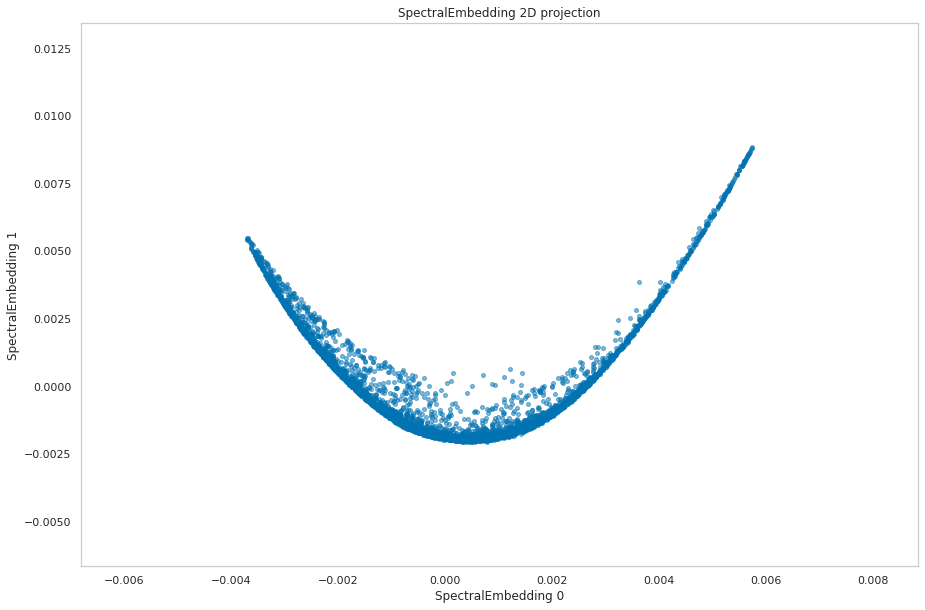

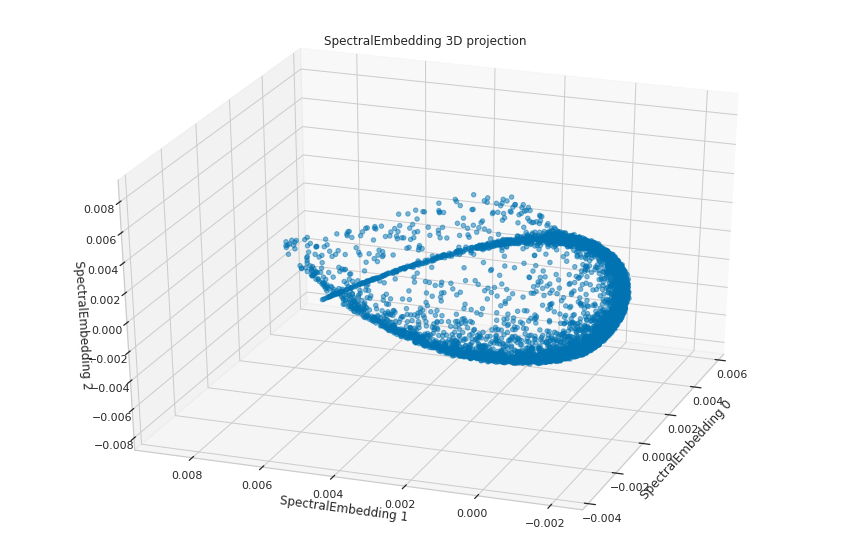

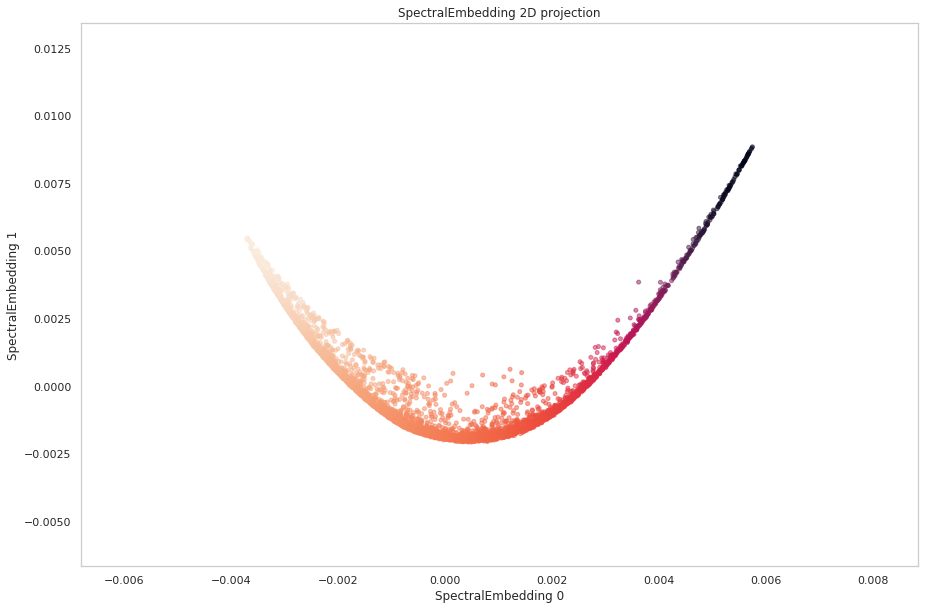

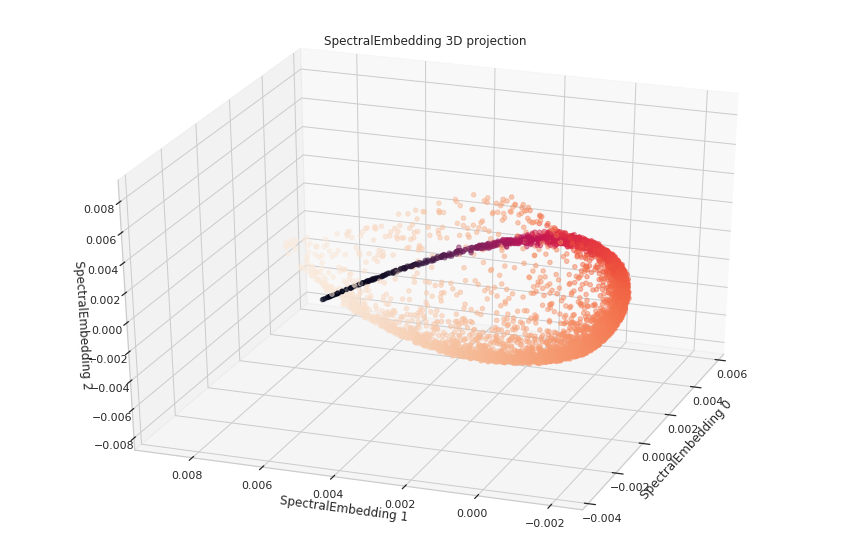

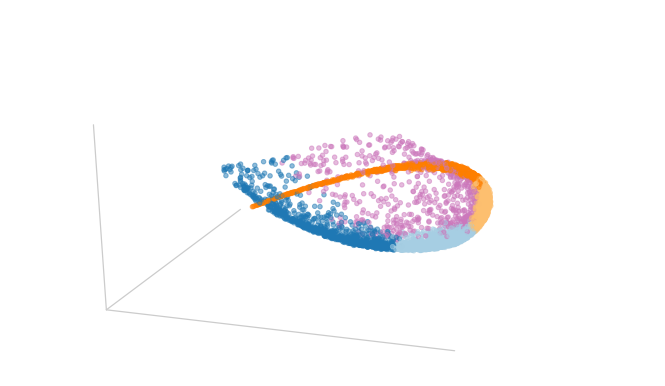

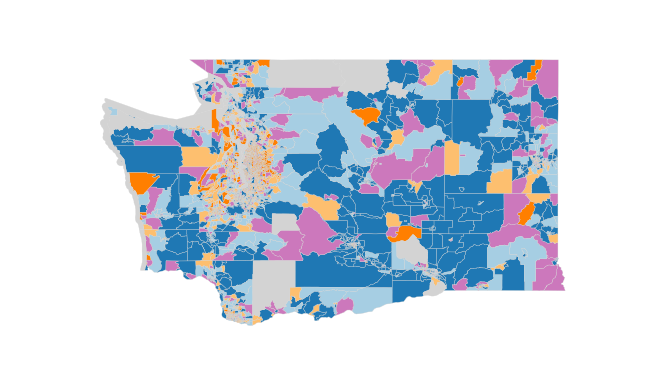

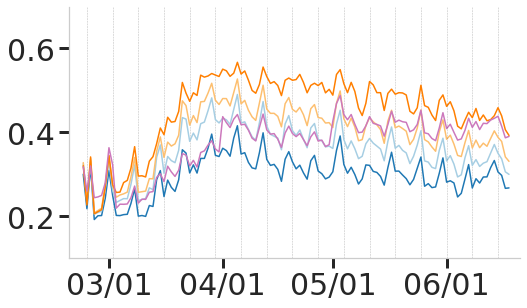

In [497]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['lines.markersize'] = 4
almost_sequential_pal = ['#1f78b4','#a6cee3','#fdbf6f','#ff7f00', '#cc78bc']
sns.set_palette(almost_sequential_pal)

method = SpectralEmbedding
hyperparams_to_test = {'n_components': [14]}# np.arange(2, max_components, 2)}
method_kwargs = {'n_neighbors': 50, 'n_components': 2, 'n_jobs': -1}

fig = plt.figure(figsize = (5*7*1.15, 5*(6.25 - 0.77)))
# ax0 = fig.add_subplot(spec[0])
states = ['wa']#, 'wa', 'ga']#change to tx!
NUM_STATES = len(states)
NUM_COLS = 3
spec = gridspec.GridSpec(ncols=NUM_COLS, nrows=NUM_STATES, width_ratios=[1, 1.1, 1], wspace=0.00, hspace=0.15)

# from matplotlib import rcParams
# rcParams['font.family'] = 'sans-serif'
# rcParams['font.sans-serif'] = ['Arial']
# rcParams['font.size'] = 2
# import matplotlib
# matplotlib.rc('font',family='Times New Roman')

for row, state in enumerate(states):
    SHAPE_PATH, FIGURE_PATH, RAW_DATA_PATH = define_paths(state)
    print('STATE: ', state)
    analysis(state, method, method_kwargs, hyperparams_to_test, fig, spec, row, precomputed = True, separate = True, two_cols = False)
# fig.subplots_adjust(hspace=0.15, wspace=0.05)
plt.tight_layout()

In [24]:
# fig.savefig(os.path.join(FIGURE_PATH, 'summary_fig_three_cols_true_size.png'), bbox_inches = 'tight', dpi = 600)

In [27]:
#Load stay-at-home data
covid_, X, index_X, columns_X = load_data(RAW_DATA_PATH) 
labels_wa = pd.read_csv(os.path.join(DATA_PATH, 'processed', 'labels_wa.csv'), index_col = 0, names = ['cluster'], header = 0)
SE_3D_wa = pd.read_csv(os.path.join(DATA_PATH, 'processed', 'SpectralEmbedding3D_wa.csv'), index_col = 0, header = 0)

Data loaded: (4752, 117) (4764, 117)


In [29]:
candidate_d

NameError: name 'candidate_df' is not defined

In [151]:
from mpl_toolkits.mplot3d.proj3d import proj_transform
from matplotlib.text import Annotation

class Annotation3D(Annotation):
    '''Annotate the point xyz with text s'''

    def __init__(self, s, xyz, *args, **kwargs):
        Annotation.__init__(self,s, xy=(0,0), *args, **kwargs)
        self._verts3d = xyz        

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.xy=(xs,ys)
        Annotation.draw(self, renderer)
        
def annotate3D(ax, s, *args, **kwargs):
    '''add anotation text s to to Axes3d ax'''

    tag = Annotation3D(s, *args, **kwargs)
    ax.add_artist(tag)


In [451]:
p = (labels_wa.cluster == 5).astype('float')*0.8 + (labels_wa.cluster != 5).astype('float')*0.2
p = p/np.sum(p)

In [460]:
np.random.seed(1)
ind_to_plot = np.random.choice(SE_3D_wa.index, 2000, p = p)
# ind_to_plot = slice(None)

[1 2 3 4 5]
530770016012    1
530330315023    2
530610521122    3
530330322033    4
530519701003    5
Name: cluster, dtype: int64
Int64Index([530770016012, 530330315023, 530610521122, 530330322033,
            530519701003],
           dtype='int64')


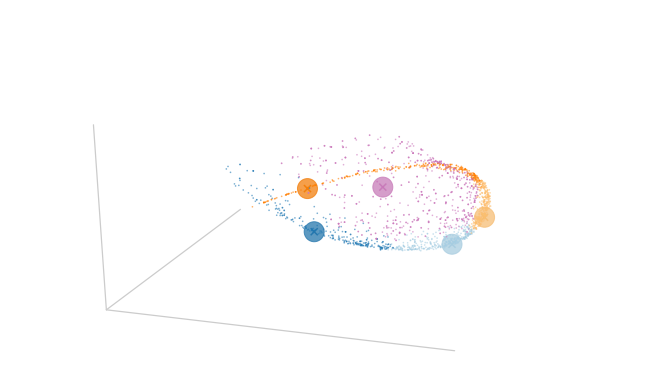

In [461]:
fig = plt.figure(figsize = (5*7/3, 5*(6.25 - 0.77)/4))
ax = fig.add_subplot(111, projection='3d')


almost_sequential_pal = ['#1f78b4','#a6cee3','#fdbf6f','#ff7f00', '#cc78bc']
friendly_cmap_backgr = ListedColormap(sns.color_palette(almost_sequential_pal, len(np.unique(reordered_SE_clusters)), desat = 1).as_hex())
friendly_cmap = ListedColormap(sns.color_palette(almost_sequential_pal, len(np.unique(reordered_SE_clusters)), desat = 0.9).as_hex())
# ind_to_plot = labels_wa.cluster != 5
ax.scatter(SE_3D_wa['Mode 0'][ind_to_plot], SE_3D_wa['Mode 1'][ind_to_plot], SE_3D_wa['Mode 2'][ind_to_plot], c = labels_wa['cluster'][ind_to_plot].values, cmap = friendly_cmap_backgr, alpha = 0.5, zorder = 0, s=0.5)

# _, X_3D_SE = viz_SE(X, labels_wa['cluster'].values, filename = None, alpha = 0.008, cbar = 'clustering', ax = ax, load_path =  os.path.join('obj', STATE), save_path = None)
if state == 'wa':
    ax.view_init(30, 200)
if state == 'ga':
    ax.view_init(30, 80)
if state == 'tx':
    ax.view_init(30, 245)
if state == 'ca':
    ax.view_init(30, 80)

ax.set_xlim(np.array([np.min(X_3D_SE[:,0]), np.max(X_3D_SE[:,0])]))
ax.set_ylim(np.array([np.min(X_3D_SE[:,1]), np.max(X_3D_SE[:,1])]))
ax.set_zlim(np.array([np.min(X_3D_SE[:,2]), np.max(X_3D_SE[:,2])]))
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_zlabel('')
plt.axis('tight')
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])#,rotation=-15, va='center', ha='right')
ax.set_xticks([]) 
ax.set_yticks([]) 
ax.set_zticks([])
ax.xaxis._axinfo['juggled'] = (0,0,1)
#     ax.dist = 5.5
# ax.yaxis._axinfo['juggled'] = (1,1,1)
# ax.zaxis._axinfo['juggled'] = (1,0,0)
ax.grid(False)
ax.set_title('')
#Highlight points:
points_to_highlight = SE_3D_wa.loc[candidate_df.index]
print(labels_wa.cluster[candidate_df.index].values)
print(labels_wa.cluster[candidate_df.index])
print(candidate_df.index)
ax.scatter(points_to_highlight['Mode 0'], points_to_highlight['Mode 1'], points_to_highlight['Mode 2'], s = 400, c = labels_wa.cluster[candidate_df.index].values, cmap = friendly_cmap, alpha = 0.75, zorder = 10)
ax.scatter(points_to_highlight['Mode 0'], points_to_highlight['Mode 1'], points_to_highlight['Mode 2'], s = 50, marker = 'x', c = labels_wa.cluster[candidate_df.index].values, cmap = friendly_cmap, alpha = 1, zorder = 10)
# ax.scatter(points_to_highlight['Mode 0'], points_to_highlight['Mode 1'], points_to_highlight['Mode 2'], marker = 'o', s = 100, facecolors = 'none')
fig.savefig(os.path.join(FIGURE_PATH, state + 'SchematicFig1_manifold.png'), bbox_inches = 'tight',  pad_inches=0, dpi = 360)

In [476]:
np.array(sns.color_palette(almost_sequential_pal, len(np.unique(reordered_SE_clusters)), desat = 0.9))*255

array([[ 38.45, 118.55, 172.55],
       [169.05, 205.05, 223.95],
       [245.9 , 190.1 , 118.1 ],
       [242.25, 127.05,  12.75],
       [199.8 , 124.2 , 185.4 ]])

In [220]:
def create_candidate_df(SE_clusters, index_X, covid_):
    SE_clusters_block_indexed = pd.Series(SE_clusters, index = index_X)
    df_CI = covid_.dropna()#[SE_clusters_block_indexed['x']==4]
    df_CI['cluster'] = SE_clusters_block_indexed.astype('int')
    df_CI['block'] = df_CI.index
    dates = df_CI.columns.drop(['cluster'])
    avg_per_clust = df_CI.groupby('cluster').nth(8)[dates]#[dates].plot()
    return avg_per_clust

In [221]:
candidate_df = create_candidate_df(labels_wa['cluster'].values, index_X, covid_.dropna())
reordered_SE_clusters = labels_wa['cluster'].values


#For the map: use these 5 blocks and their colors
#Use them as scatter3d, load embeddings, highlight them
#potentially, plot the 5 time series separately (set block as index and turn on legend, use subplots in pandas plotting to plot seaprately)
#presentation: brief recap + gifs from wiki + resulting figures

In [65]:
candidate_df

,2020/02/23,2020/02/24,2020/02/25,2020/02/26,2020/02/27,2020/02/28,2020/02/29,2020/03/01,2020/03/02,2020/03/03,...,2020/06/10,2020/06/11,2020/06/12,2020/06/13,2020/06/14,2020/06/15,2020/06/16,2020/06/17,2020/06/18,block
cluster,,,,,,,,,,,,,,,,,,,,,
1,0.280899,0.170213,0.415842,0.168317,0.173077,0.152174,0.191489,0.195876,0.200000,0.178947,...,0.236559,0.272727,0.278351,0.340000,0.329545,0.310345,0.322581,0.304348,0.238636,530530725042
2,0.244444,0.048780,0.341463,0.131579,0.136364,0.081081,0.268293,0.085714,0.157895,0.135135,...,0.319149,0.361702,0.333333,0.294118,0.382979,0.434783,0.340909,0.304348,0.244444,530330324024
3,0.425000,0.222222,0.456522,0.212766,0.127273,0.104167,0.229167,0.404762,0.200000,0.194444,...,0.192308,0.395349,0.444444,0.234043,0.358974,0.348837,0.255814,0.333333,0.400000,530330277024
4,0.520000,0.428571,0.490196,0.333333,0.272727,0.350000,0.595238,0.685185,0.409836,0.177419,...,0.410959,0.528571,0.675676,0.456790,0.585714,0.494118,0.493506,0.390625,0.476923,530499508002
5,0.148148,0.176471,0.226415,0.070175,0.109091,0.196429,0.259259,0.166667,0.224490,0.101695,...,0.352941,0.313725,0.490909,0.392857,0.387755,0.541667,0.551020,0.480769,0.292308,530330226035


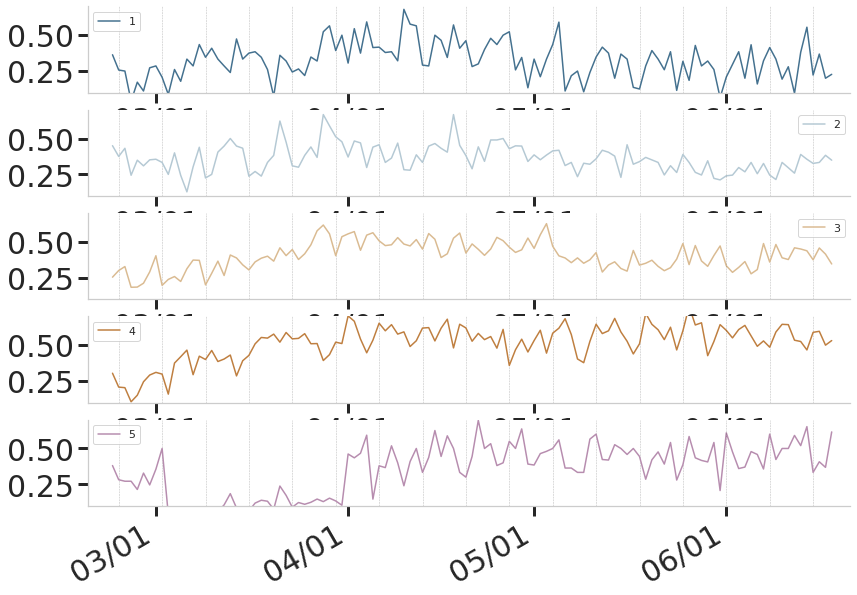

In [256]:
# fig = plt.figure(figsize = (5*7/3+2, 5*(6.25 - 0.77)/4))
# ax = fig.add_subplot(111)

plot_df = candidate_df.se.drop('block', axis = 1).T
plot_df.index = [pd.to_datetime(date, format='%Y-%m-%d').date() for date in plot_df.index]

almost_sequential_pal = ['#1f78b4','#a6cee3','#fdbf6f','#ff7f00', '#cc78bc']
friendly_cmap = ListedColormap(sns.color_palette(almost_sequential_pal, len(np.unique(reordered_SE_clusters)), desat = 0.5).as_hex())

axs = plot_df.plot(figsize = (5*7/3+2, 5*(6.25 - 0.77)/4), subplots = True, ylim = [0.1, 0.7], legend = True, cmap = friendly_cmap) 
for ax in axs:
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))

    ax.xaxis.set_minor_locator(mdates.WeekdayLocator(byweekday=MO, interval=1))
    ax.tick_params(which='minor', length=0, color='r')
    ax.tick_params(axis = 'both', length=10, width=3, which='major')
    ax.axvline(datetime(2020, 6, 1), color = 'k', alpha = .3, ls='--', lw =.5)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    #         ax.xticks(fontsize=11*5)
    #         ax.yticks(fontsize=11*5)
    ax.tick_params(axis='both', which='major', labelsize=6*5)
    ax.grid(True, 'minor', 'x', ls='--', lw=.5, c='k', alpha=.3)
    ax.set_xlim([datetime(2020, 2, 19), datetime(2020, 6, 21)])    


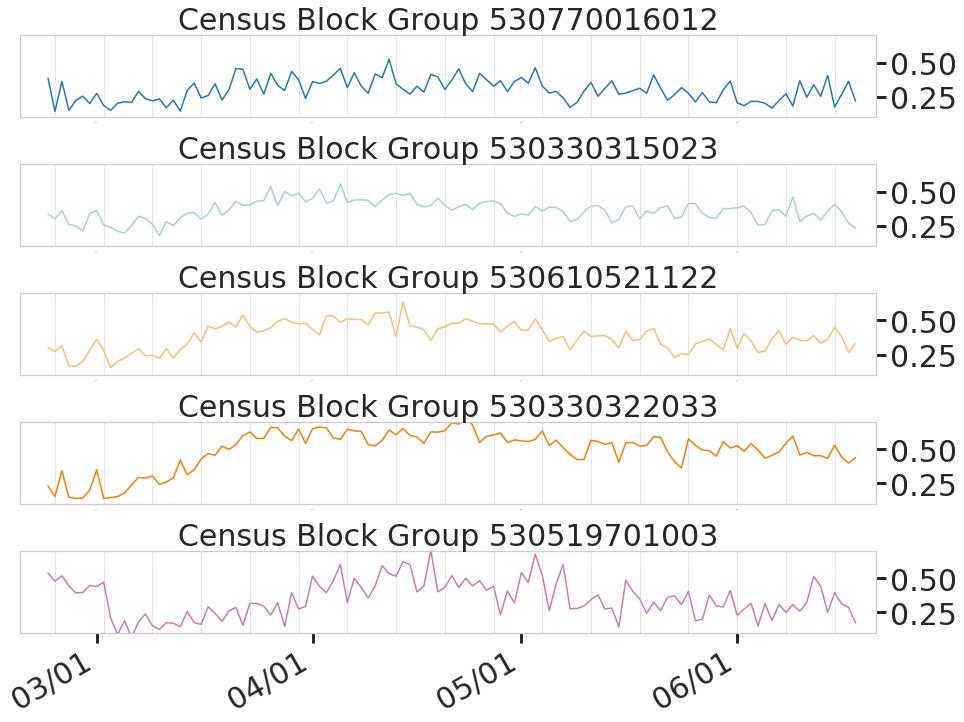

In [493]:
# fig = plt.figure(figsize = (5*7/3+2, 5*(6.25 - 0.77)/4))
# ax = fig.add_subplot(111)

plot_df = candidate_df.T
plot_df.index = [pd.to_datetime(date, format='%Y-%m-%d').date() for date in plot_df.index]

almost_sequential_pal = ['#1f78b4','#a6cee3','#fdbf6f','#ff7f00', '#cc78bc']
friendly_cmap = ListedColormap(sns.color_palette(almost_sequential_pal, len(np.unique(reordered_SE_clusters)), desat = 0.9).as_hex())

axs = plot_df.plot(figsize = (5*7/3+2, 5*2.04), subplots = True, ylim = [0.1, 0.7], legend = False, cmap = friendly_cmap) 
for i, ax in enumerate(axs):
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))

    ax.xaxis.set_minor_locator(mdates.WeekdayLocator(byweekday=MO, interval=1))
    ax.tick_params(which='minor', length=0, color='r')
    ax.axvline(datetime(2020, 6, 1), color = 'k', alpha = .3, ls='--', lw =.5)
    
#     ax.spines['left'].set_visible(False)
#     ax.spines['top'].set_visible(False)
    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('right')
    ax.xaxis.set_ticks_position('bottom')
    #         ax.xticks(fontsize=11*5)
    #         ax.yticks(fontsize=11*5)
    ax.set_title('Census Block Group {}'.format(plot_df.columns[i]), fontsize=5*6)
    ax.grid(True, 'minor', 'x', ls='--', lw=.5, c='k', alpha=.3)
    ax.set_xlim([datetime(2020, 2, 19), datetime(2020, 6, 21)]) 
    ax.yaxis.tick_right()
#     ax.legend(prop={'size': 6*5})
    if i < len(axs) - 1:
        ax.tick_params(axis = 'y', length=10, width=3, which='major')
        ax.tick_params(axis = 'x', length=0, width=3, which='major')
        ax.tick_params(axis='both', which='major', labelsize=6*5)
        ax.tick_params(axis='x', which='major', labelsize=0)
    else:
        ax.tick_params(axis='both', which='major', labelsize=6*5)
        ax.tick_params(axis = 'both', length=10, width=3, which='major')
plt.tight_layout()
plt.savefig(os.path.join(FIGURE_PATH, state + 'SchematicFig1_time_series.png'), bbox_inches = 'tight',  pad_inches=0, dpi = 360)

In [468]:
candidate_df

,2020/02/23,2020/02/24,2020/02/25,2020/02/26,2020/02/27,2020/02/28,2020/02/29,2020/03/01,2020/03/02,2020/03/03,...,2020/06/09,2020/06/10,2020/06/11,2020/06/12,2020/06/13,2020/06/14,2020/06/15,2020/06/16,2020/06/17,2020/06/18
530770016012,0.387097,0.142857,0.362319,0.150000,0.223881,0.254237,0.200000,0.275362,0.185714,0.150685,...,0.183099,0.367647,0.246575,0.338028,0.253333,0.405797,0.174603,0.266667,0.363636,0.218750
530330315023,0.336134,0.300752,0.358779,0.259542,0.248120,0.210526,0.338983,0.361538,0.255814,0.238462,...,0.460870,0.278689,0.320000,0.341270,0.291339,0.355372,0.406780,0.353448,0.269841,0.230088
530610521122,0.298851,0.273810,0.313253,0.168539,0.162791,0.200000,0.282353,0.362637,0.280899,0.153846,...,0.376623,0.354430,0.350649,0.390244,0.333333,0.361446,0.447368,0.380952,0.265823,0.333333
530330322033,0.231132,0.153488,0.343137,0.149533,0.140000,0.143541,0.200980,0.351111,0.139640,0.147321,...,0.597087,0.458333,0.477876,0.453333,0.453704,0.433333,0.530233,0.444444,0.399083,0.439815
530519701003,0.538462,0.478261,0.517857,0.444444,0.392157,0.395833,0.446809,0.440000,0.470588,0.209302,...,0.307692,0.258065,0.324324,0.513514,0.441860,0.250000,0.393939,0.312500,0.285714,0.172414


In [264]:
labels_wa.loc[candidate_df.block]

,cluster
530530718033,1
530499502005,2
530610538012,3
530330072002,4
530330116006,5


In [300]:
def create_candidate_df(SE_clusters, index_X, covid_):
    SE_clusters_block_indexed = pd.Series(SE_clusters, index = index_X)
    df_CI = covid_.dropna()#[SE_clusters_block_indexed['x']==4]
    df_CI['cluster'] = SE_clusters_block_indexed.astype('int')
    df_CI['block'] = df_CI.index
    dates = df_CI.columns.drop(['cluster'])
    avg_per_clust = df_CI.groupby('cluster').nth(25)[dates]#[dates].plot()
    return avg_per_clust

In [301]:
candidate_df = create_candidate_df(labels_wa['cluster'].values, index_X, covid_.dropna())
reordered_SE_clusters = labels_wa['cluster'].values

In [354]:
labels_wa[labels_wa.cluster.isin([2])]

,cluster
530079605005,2
530330303092,2
530579514003,2
530610407003,2
530179502002,2
...,...
530350901021,2
530330297004,2
530330121001,2
530330315023,2


In [319]:
labels_wa.cluster[blocks]

530330322033    4
530770016012    1
530519701003    5
Name: cluster, dtype: int64

In [304]:
covid_

,2020/02/23,2020/02/24,2020/02/25,2020/02/26,2020/02/27,2020/02/28,2020/02/29,2020/03/01,2020/03/02,2020/03/03,...,2020/06/09,2020/06/10,2020/06/11,2020/06/12,2020/06/13,2020/06/14,2020/06/15,2020/06/16,2020/06/17,2020/06/18
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
530110428002,0.220339,0.250000,0.308824,0.171875,0.220588,0.228070,0.276316,0.236842,0.309859,0.240964,...,0.484375,0.422535,0.471429,0.548387,0.434211,0.476923,0.491228,0.421875,0.449275,0.367647
530330100013,0.367347,0.214286,0.403509,0.358491,0.280000,0.226415,0.339286,0.351351,0.185714,0.246575,...,0.596491,0.518519,0.607143,0.618182,0.611111,0.636364,0.571429,0.622642,0.428571,0.563636
530530725072,0.376471,0.197802,0.302083,0.120000,0.153846,0.207317,0.259259,0.351064,0.222222,0.225806,...,0.348837,0.384615,0.342105,0.297297,0.329114,0.283951,0.328767,0.282051,0.273973,0.202899
530610521122,0.298851,0.273810,0.313253,0.168539,0.162791,0.200000,0.282353,0.362637,0.280899,0.153846,...,0.376623,0.354430,0.350649,0.390244,0.333333,0.361446,0.447368,0.380952,0.265823,0.333333
530610538033,0.388235,0.277778,0.340659,0.273810,0.311111,0.264368,0.467532,0.406593,0.381443,0.216981,...,0.328571,0.413333,0.410256,0.405405,0.538462,0.493506,0.480000,0.455882,0.366197,0.376812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
530330293043,0.400000,0.283019,0.320755,0.203704,0.254545,0.211538,0.408163,0.428571,0.306452,0.241379,...,0.283333,0.327586,0.220339,0.315789,0.295082,0.345455,0.327273,0.288462,0.258621,0.272727
530330315023,0.336134,0.300752,0.358779,0.259542,0.248120,0.210526,0.338983,0.361538,0.255814,0.238462,...,0.460870,0.278689,0.320000,0.341270,0.291339,0.355372,0.406780,0.353448,0.269841,0.230088
530330323174,0.196429,0.200000,0.262295,0.078125,0.131148,0.166667,0.263158,0.267857,0.321429,0.226415,...,0.542373,0.457627,0.509091,0.423077,0.419355,0.463768,0.439394,0.475410,0.439394,0.456140


In [372]:
# labels_wa['cluster'][[530330322033,530330305031,530770016012,530519701003]]
blocks = [530330322033,530770016012,530519701003,   530610521122,        530330315023]
candidate_df = covid_.loc[blocks].loc[labels_wa.cluster[blocks].sort_values().index]

In [375]:
candidate_df

,2020/02/23,2020/02/24,2020/02/25,2020/02/26,2020/02/27,2020/02/28,2020/02/29,2020/03/01,2020/03/02,2020/03/03,...,2020/06/09,2020/06/10,2020/06/11,2020/06/12,2020/06/13,2020/06/14,2020/06/15,2020/06/16,2020/06/17,2020/06/18
530770016012,0.387097,0.142857,0.362319,0.150000,0.223881,0.254237,0.200000,0.275362,0.185714,0.150685,...,0.183099,0.367647,0.246575,0.338028,0.253333,0.405797,0.174603,0.266667,0.363636,0.218750
530330315023,0.336134,0.300752,0.358779,0.259542,0.248120,0.210526,0.338983,0.361538,0.255814,0.238462,...,0.460870,0.278689,0.320000,0.341270,0.291339,0.355372,0.406780,0.353448,0.269841,0.230088
530610521122,0.298851,0.273810,0.313253,0.168539,0.162791,0.200000,0.282353,0.362637,0.280899,0.153846,...,0.376623,0.354430,0.350649,0.390244,0.333333,0.361446,0.447368,0.380952,0.265823,0.333333
530330322033,0.231132,0.153488,0.343137,0.149533,0.140000,0.143541,0.200980,0.351111,0.139640,0.147321,...,0.597087,0.458333,0.477876,0.453333,0.453704,0.433333,0.530233,0.444444,0.399083,0.439815
530519701003,0.538462,0.478261,0.517857,0.444444,0.392157,0.395833,0.446809,0.440000,0.470588,0.209302,...,0.307692,0.258065,0.324324,0.513514,0.441860,0.250000,0.393939,0.312500,0.285714,0.172414


In [371]:
labels_wa.cluster[blocks].sort_values()

530770016012    1
530330315023    2
530610521122    3
530330322033    4
530519701003    5
Name: cluster, dtype: int64

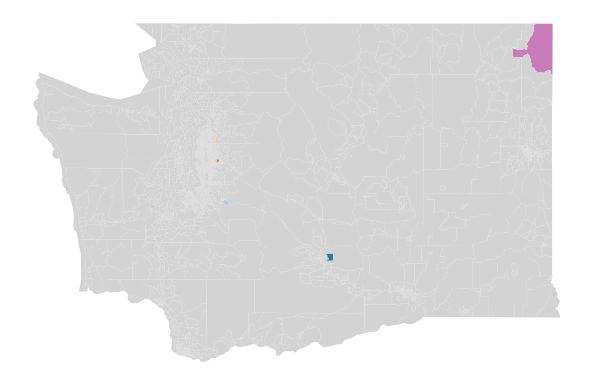

In [469]:
fig = plt.figure(figsize = (5*7/3+2, 5*(6.25 - 0.77)/4))
ax = fig.add_subplot(111)
viz_cluster_map(labels_wa.loc[blocks].values, blocks, filename = None, title = None, cbar_label = None, cmap = 'clust', ax = ax, edgecolor = 'white', linewidth = 0.01)
fig.savefig(os.path.join(FIGURE_PATH, state + 'SchematicFig1_map.png'), bbox_inches = 'tight',  pad_inches=0, dpi = 360)

In [277]:
viz_blocks_on_the_map(candidate_df.block, colors = labels_wa.loc[candidate_df.block].values, name = 'blocks_of_interest', filename = None, cmap = 'clust')

/home/rlevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


TypeError: NumPy boolean array indexing assignment requires a 0 or 1-dimensional input, input has 2 dimensions